# DDoS Attack Detection System
#### Focusing on SYN, UDP, and WebDDoS (HTTP) attacks from CIC-DDoS2019 dataset

## 1. Data Collection and Preprocessing

### 1.1 Initial Setup

In [1]:
# Standard Library Imports
import os
import gc
import json
import logging
import time
import warnings
import re

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import joblib
from tqdm.auto import tqdm
from scipy import sparse

# Scikit-Learn Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
)
from sklearn.preprocessing import StandardScaler

# XGBoost Imports
from xgboost import XGBClassifier

# Configuration
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, 
                   format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('DDoS_Detection')

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.2
CHUNKSIZE = 100000
MIN_SAMPLES = 5000

# Directory Setup
dirs_to_create = [
    "models",
    "results/plots",
    "results/plots/confusion_matrices",
    "results/plots/feature_importance",
    "results/plots/performance_curves",
    "results/metrics",
    "results/error_analysis",
    "results/plots/feature_analysis",
    "results/plots/tuning"
]

for directory in dirs_to_create:
    os.makedirs(directory, exist_ok=True)

### 1.2 Data Loading and Cleaning

2025-05-17 13:58:44,776 - INFO - Loading dataset...


Original labels:
 ['UDP' 'MSSQL' 'BENIGN' 'PORTMAP' 'SYN' 'NETBIOS' 'UDPLAG' 'LDAP'
 'DRDOS_DNS' 'UDP-LAG' 'WEBDDOS' 'TFTP' 'DRDOS_UDP' 'DRDOS_SNMP'
 'DRDOS_NETBIOS' 'DRDOS_LDAP' 'DRDOS_MSSQL' 'DRDOS_NTP']


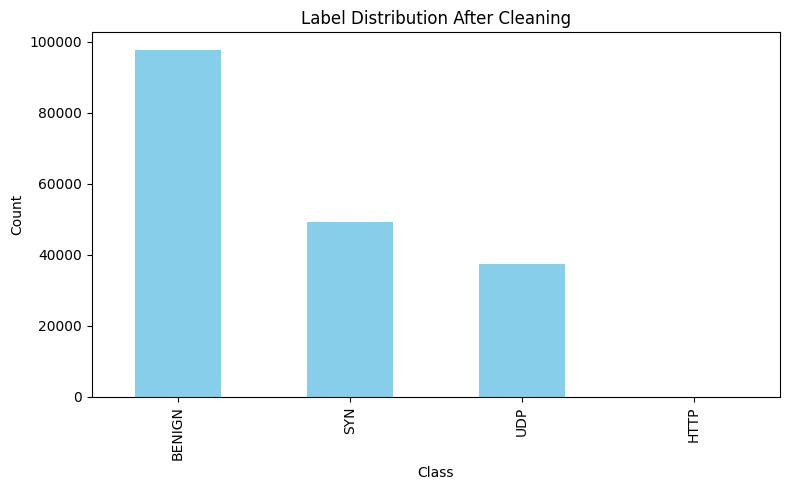

3208

In [2]:
def load_and_clean():
    essential_cols = ['Flow Duration', 'Total Fwd Packets', 'Protocol', 
                      'SYN Flag Count', 'Fwd Packets/s', 'Label']
    try:
        logger.info("Loading dataset...")
        chunks = pd.read_csv("data/cicddos2019_dataset.csv", 
                             chunksize=CHUNKSIZE, usecols=essential_cols)
        dataset = pd.concat(chunks)

        dataset['Label'] = dataset['Label'].str.upper()
        original_labels = dataset['Label'].unique()
        print("Original labels:\n", original_labels)

        # Explicit label mappings for selected attack types
        flat_label_mapping = {
            'UDP': 'UDP',
            'UDP-LAG': 'UDP',
            'UDPLAG': 'UDP',
            'DRDOS_UDP': 'UDP',
            'SYN': 'SYN',
            'WEBDDOS': 'HTTP',
            'BENIGN': 'BENIGN'
        }

        # Apply mapping
        dataset['Label'] = dataset['Label'].map(flat_label_mapping)

        # Keep only desired classes
        dataset = dataset[dataset['Label'].isin(['UDP', 'SYN', 'HTTP', 'BENIGN'])].copy()

        # Show cleaned label distribution
        plt.figure(figsize=(8, 5))
        dataset['Label'].value_counts().plot(kind='bar', color='skyblue')
        plt.title("Label Distribution After Cleaning")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig("results/plots/class_distribution.png")
        plt.show()
        plt.close()

        return dataset

    except Exception as e:
        logger.error(f"Data loading failed: {e}")
        raise

dataset = load_and_clean()

train_df, test_df = train_test_split(
    dataset,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['Label']
)

del dataset
gc.collect()

### 1.3 Feature Engineering and Processing

2025-05-17 13:58:46,853 - INFO - Saved label encoder


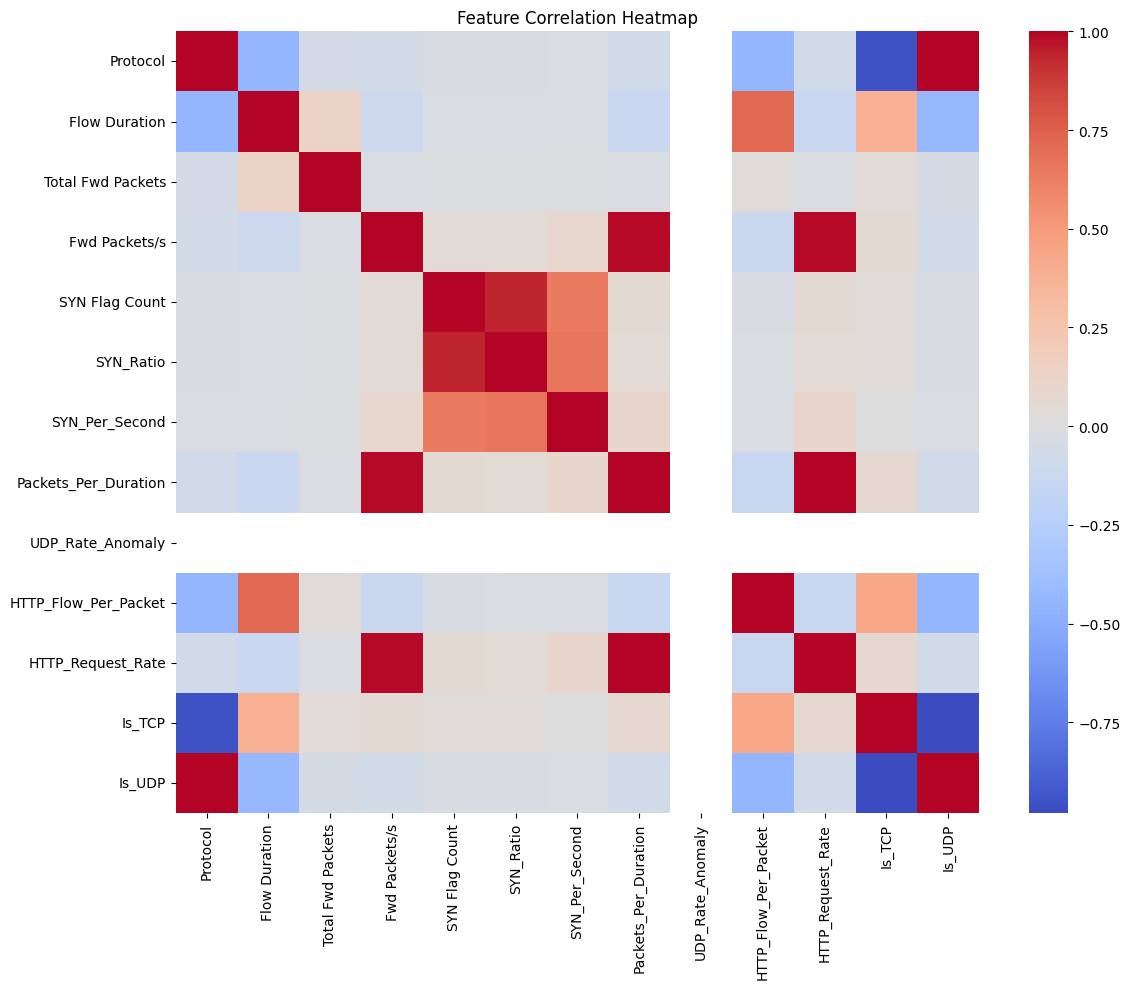

2025-05-17 13:58:47,916 - INFO - Saved preprocessor


In [3]:
# Protocol-specific feature engineering (BEFORE preprocessing)
def add_engineered_features(df, udp_threshold=None):
    """Enhanced feature engineering with more robust calculations"""
    # Add input validation
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
        
    required_cols = ['SYN Flag Count', 'Total Fwd Packets', 'Fwd Packets/s', 'Flow Duration']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame missing required columns: {required_cols}")
    
    # Enhanced SYN features
    df['SYN_Ratio'] = df['SYN Flag Count'] / (df['Total Fwd Packets'].replace(0, 1))
    df['SYN_Per_Second'] = df['SYN Flag Count'] / (df['Flow Duration'] / 1e6 + 1e-6)
    df['Packets_Per_Duration'] = df['Total Fwd Packets'] / (df['Flow Duration'] / 1e6 + 1e-6)

    # More robust UDP threshold calculation
    if udp_threshold is None:
        udp_threshold = df.loc[df['Protocol'] == 17, 'Fwd Packets/s'].quantile(0.999)
    df['UDP_Rate_Anomaly'] = ((df['Protocol'] == 17) & 
                             (df['Fwd Packets/s'] > udp_threshold)).astype(int)
    
    # Enhanced HTTP features
    df['HTTP_Flow_Per_Packet'] = np.where(
        df['Total Fwd Packets'] > 0,
        df['Flow Duration'] / (df['Total Fwd Packets'] * 1e6),  # Convert to seconds
        0
    )
    df['HTTP_Request_Rate'] = df['Total Fwd Packets'] / (df['Flow Duration'] / 1e6 + 1e-6)
    
    # Add protocol-specific flags
    df['Is_TCP'] = (df['Protocol'] == 6).astype(int)
    df['Is_UDP'] = (df['Protocol'] == 17).astype(int)
    
    return df, udp_threshold

def get_feature_names(preprocessor):
    """Safe feature names extraction"""
    try:
        return preprocessor.get_feature_names_out()
    except AttributeError:  # For older sklearn
        return [f'f{i}' for i in range(preprocessor.n_features_in_)]

# Handle missing values
train_medians = train_df.select_dtypes(include='number').median()
train_df = train_df.fillna(train_medians)
test_df = test_df.fillna(train_medians)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Label'])
y_test = label_encoder.transform(test_df['Label'])
class_names = label_encoder.classes_
joblib.dump(label_encoder, "models/label_encoder.pkl")
logger.info("Saved label encoder")
# Balance classes
balanced_train = pd.concat([
    resample(train_df[train_df['Label'] == label],
             n_samples=max(MIN_SAMPLES, (train_df['Label'] == label).sum()),
             random_state=RANDOM_STATE)
    for label in train_df['Label'].unique()
])

train_df, udp_threshold = add_engineered_features(train_df)

plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("results/plots/feature_analysis/correlation_heatmap.png", dpi=300)
plt.show()
plt.close()

test_df, _ = add_engineered_features(test_df, udp_threshold=udp_threshold)

X_train = balanced_train.drop('Label', axis=1)
y_train = balanced_train['Label']

# Preprocessing - includes engineered features
numeric_cols = balanced_train.drop(columns=['Label']).select_dtypes(include='number').columns
preprocessor = ColumnTransformer([('num', MinMaxScaler(), numeric_cols)], remainder='passthrough')
X_train = balanced_train.drop(columns=['Label'])  # drop before fit
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(test_df.drop(columns=['Label']))
joblib.dump(preprocessor, "models/preprocessor.pkl")
logger.info("Saved preprocessor")
selected_features = get_feature_names(preprocessor)

## 2. Model Training and Evaluation

### 2.1 Setup and Utilities

In [4]:
class TrainingMonitor:
    """Live training progress tracker"""
    def __init__(self):
        self.pbar = tqdm(desc="Training", unit="iter")
        self.mem_history = []

    def __call__(self, epoch, _):
        self.pbar.update(1)
        mem = psutil.Process().memory_info().rss / (1024 ** 2)
        self.mem_history.append(mem)
        self.pbar.set_postfix(mem_mb=mem)

def check_gpu_available():
    """Check if GPU is available for XGBoost"""
    try:
        from xgboost import XGBClassifier
        import numpy as np
        X = np.array([[0], [1]])
        y = np.array([0, 1])
        XGBClassifier(tree_method='gpu_hist', use_label_encoder=False).fit(X, y)
        return True
    except Exception as e:
        print(f"[XGBoost GPU Test] {e}")
        return False
    
def evaluate_model(model, X_test, y_test, class_names, selected_features, plot=True):
    try:
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, 
                                       output_dict=True,
                                       target_names=class_names)
        
        metrics = {
            'accuracy': float(accuracy_score(y_test, y_pred)),
            'balanced_accuracy': float(balanced_accuracy_score(y_test, y_pred)),
            'class_reports': {
                cls: {
                    'precision': float(report[cls]['precision']),
                    'recall': float(report[cls]['recall']),
                    'f1-score': float(report[cls]['f1-score']),
                    'support': int(report[cls]['support'])
                } for cls in class_names
            }
        }
        
        return metrics
        
    except Exception as e:
        logger.error(f"Evaluation failed: {e}")
        return None
        
# Visualisation
def plot_feature_importance(model, model_name, features=None):
    """Enhanced feature importance visualisation"""
    if hasattr(model, 'feature_importances_'):
        if features is None:
            features = [f'f{i}' for i in range(len(model.feature_importances_))]
            
        importance = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance.head(20))
        plt.title(f'{model_name} Feature Importance')
        plt.tight_layout()
        plt.savefig(f"results/plots/feature_importance/{model_name}.png", dpi=300)
        plt.show()
        plt.close()

def plot_training_curves(model, model_name):
    """Plot XGBoost training metrics"""
    if hasattr(model, 'evals_result_'):
        results = model.evals_result()
        plt.figure(figsize=(10, 6))
        
        for metric in results['validation_0']:
            plt.plot(results['validation_0'][metric], label=f'Train {metric}')
            if 'validation_1' in results:
                plt.plot(results['validation_1'][metric], label=f'Val {metric}')
        
        plt.title('Training Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"results/plots/performance_curves/{model_name}_training.png", dpi=300)
        plt.show()
        plt.close()

def safe_filename(name):
    """Sanitize feature name to be safe for file paths."""
    name = re.sub(r'[^\w\-_. ]', '_', name)   # Replace unsafe chars
    name = name.replace(' ', '_')             # Replace spaces
    return name[:50]  # Trim to avoid overly long names

def plot_feature_distributions(
    X, y, feature_names, 
    output_dir="results/plots/feature_analysis", 
    max_rows=5000, 
    max_features=10
):
    os.makedirs(output_dir, exist_ok=True)
    
    df = pd.DataFrame(X, columns=feature_names)
    df['Label'] = y

    # Sample if dataset is too large
    if len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=42)

    for col in feature_names[:max_features]:
        try:
            if df[col].nunique() <= 1 or df[col].std() < 1e-6:
                continue  # skip flat features

            safe_col = safe_filename(col)

            plt.figure(figsize=(8, 4))

            # Histogram (faded background)
            sns.histplot(data=df, x=col, hue='Label', 
                         element='step', common_norm=False, 
                         stat="density", alpha=0.3)

            # KDE (overlay)
            sns.kdeplot(data=df, x=col, hue='Label', 
                        common_norm=False, linewidth=2)

            plt.title(f'Distribution of {col} by Label')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{safe_col}_distribution.png"), dpi=300)
            plt.show()
            plt.close()

        except Exception as e:
            print(f"[WARN] Could not plot {col}: {e}")
            plt.close()

### 2.2 Model Training

In [5]:
def train_random_forest(X_train, y_train, selected_features=None):
    """Simplified Random Forest training without batch processing"""
    try:
        logger.info("\nTraining Random Forest...")
        
        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
        class_weight_dict[1] *= 2  # Slightly increase the weight for class 1 to handle imbalance

        model = RandomForestClassifier(
            n_estimators=200,  # Increased number of trees for more robust results
            max_depth=20,       # Controlled depth to avoid overfitting
            min_samples_split=5,  # Minimum samples for splitting nodes to avoid overfitting
            min_samples_leaf=2,  # Minimum samples in leaf nodes
            max_features='sqrt',  # Using square root of features for better generalisation
            class_weight=class_weight_dict,  # Apply class balancing
            random_state=RANDOM_STATE,
            n_jobs=-1,  # Parallel processing for faster training
            verbose=1    # More detailed logging
        )
        
        # Simple fit without batches
        model.fit(X_train, y_train)
        
        joblib.dump(model, "models/random_forest_model.pkl")
        logger.info("Saved Random Forest model")
        
        if selected_features is not None and hasattr(model, 'feature_importances_'):
            plot_feature_importance(model, "RandomForest", selected_features)
        
        return model
        
    except Exception as e:
        logger.error(f"RF training failed: {e}")
        raise

def train_svm(X_train, y_train, selected_features=None):
    """Train SVM using SGD for large-scale learning"""
    try:
        logger.info("\nTraining SVM with SGD...")
        
        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced', 
            classes=np.unique(y_train), 
            y=y_train
        )
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

        # Initialise linear SVM with SGD
        model = SGDClassifier(
            loss='modified_huber',  # SVM equivalent, robust to noise
            penalty='l2',
            alpha=0.0001,
            max_iter=2000,
            tol=1e-3,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            learning_rate='adaptive',  # Adaptive learning rate
            class_weight=class_weight_dict,  # Auto-balance classes
            eta0=0.01
        )
        
        # Batch training
        batch_size = 10000
        for batch_idx in tqdm(range(0, len(X_train), batch_size), desc="SGD Training"):
            end_idx = min(batch_idx + batch_size, len(X_train))
            model.partial_fit(
                X_train[batch_idx:end_idx],
                y_train[batch_idx:end_idx],
                classes=np.unique(y_train)
            )
        
        # Save model and plot coefficients if available
        joblib.dump(model, "models/svm_sgd_model.pkl")
        logger.info("Saved SGD SVM model")
        
        if selected_features is not None and hasattr(model, 'coef_'):
            plt.figure(figsize=(10, 6))
            pd.Series(np.abs(model.coef_[0]), 
                     index=selected_features).nlargest(20).plot.barh()
            plt.title('SVM Feature Coefficients (Absolute Values)')
            plt.tight_layout()
            plt.savefig("results/plots/svm_coefficients.png")
            plt.show()
            plt.close()
        
        return model
        
    except Exception as e:
        logger.error(f"SVM training failed: {e}")
        raise

def train_xgboost(X_train, y_train, selected_features=None):
    """Train XGBoost with GPU support detection"""
    try:
        logger.info("\nTraining XGBoost...")
        
        gpu_available = check_gpu_available()
        logger.info(f"GPU available: {gpu_available}")

        # Create validation set
        X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
            X_train, y_train, 
            test_size=0.2, 
            random_state=RANDOM_STATE,
            stratify=y_train
        )
        
        # Handle class imbalance
        scale_pos_weight = len(y_train_xgb[y_train_xgb == 0]) / len(y_train_xgb[y_train_xgb == 1])
        
        model = XGBClassifier(
            tree_method='gpu_hist' if gpu_available else 'hist',  # Use GPU if available
            objective='multi:softmax',  # Use softmax for direct class predictions
            num_class=len(np.unique(y_train_xgb)),
            eval_metric=['mlogloss', 'merror'],  # Multiple eval metrics for better understanding
            learning_rate=0.05,  # Tuned learning rate
            max_depth=12,  # Slightly deeper trees
            n_estimators=500,  # Larger number of estimators
            subsample=0.8,
            colsample_bytree=0.8,
            use_label_encoder=False,
            random_state=RANDOM_STATE,
            scale_pos_weight=scale_pos_weight
        )
        
        model.fit(
            X_train_xgb, y_train_xgb,
            eval_set=[(X_val_xgb, y_val_xgb)],
            verbose=10
        )
        
        joblib.dump(model, "models/xgboost_model.pkl")
        logger.info("Saved XGBoost model")
        
        if hasattr(model, 'evals_result_'):
            plot_training_curves(model, "XGBoost")
            
        if selected_features is not None:
            plot_feature_importance(model, "XGBoost", selected_features)
        
        return model
        
    except Exception as e:
        logger.error(f"XGBoost training failed: {e}")
        raise

### 2.3 Main Training Pipeline

2025-05-17 13:58:48,011 - INFO - Current memory usage: 299.74 MB
2025-05-17 13:58:48,041 - INFO - 
Starting feature selection pipeline...


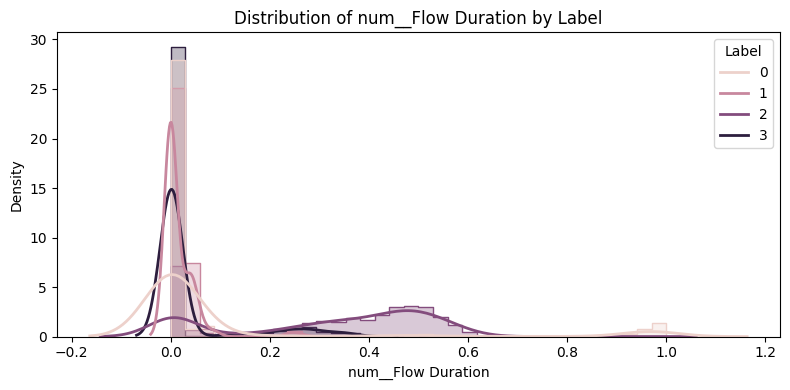

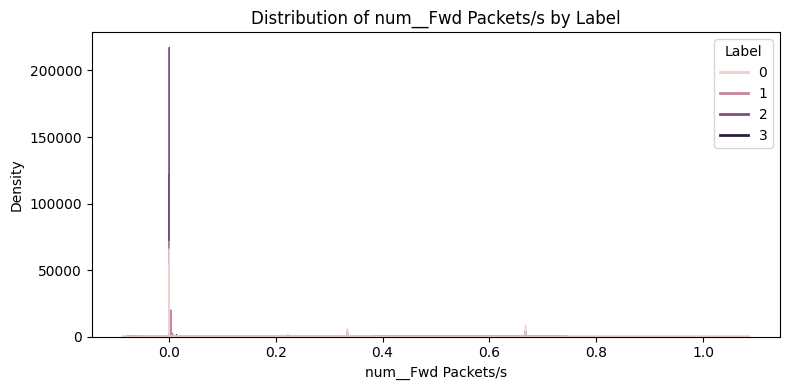

2025-05-17 13:59:01,132 - INFO - 
=== Data Validation ===
2025-05-17 13:59:01,132 - INFO - Unique y_train values: [0 1 2 3]
2025-05-17 13:59:01,144 - INFO - Class distribution: 0    78265
2    39498
3    29949
1     5000
Name: count, dtype: int64
2025-05-17 13:59:01,144 - INFO - 
Training models...
2025-05-17 13:59:01,144 - INFO - 
Training Random Forest...
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.1s finished
2025-05-17 13:59:04,558 - INFO - Saved Random Forest model


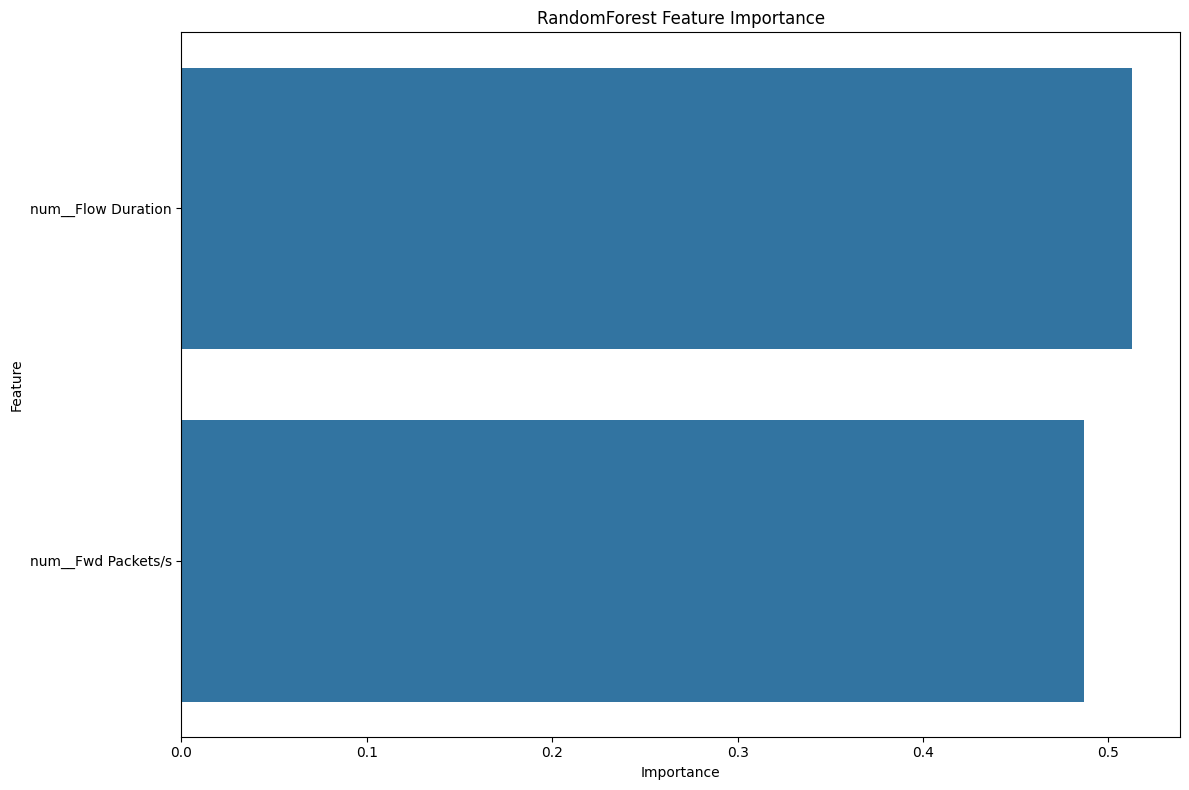

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished
2025-05-17 13:59:05,136 - INFO - RF sample predictions: [0 3 0 3 2]
2025-05-17 13:59:05,142 - INFO - 
Training SVM with SGD...


SGD Training:   0%|          | 0/16 [00:00<?, ?it/s]

2025-05-17 13:59:05,648 - INFO - Saved SGD SVM model


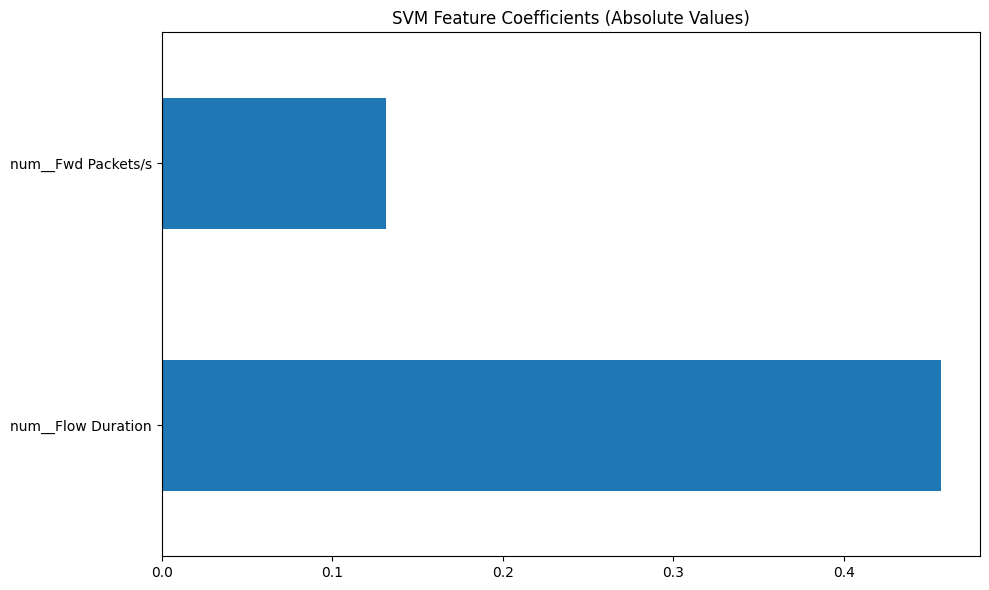

2025-05-17 13:59:05,837 - INFO - SVM sample predictions: [1 1 1 1 1]
2025-05-17 13:59:05,837 - INFO - 
Training XGBoost...
2025-05-17 13:59:05,868 - INFO - GPU available: False


[XGBoost GPU Test] [13:59:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [13:59:05] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device

[0]	validation_0-mlogloss:1.31801	validation_0-merror:0.13191
[10]	validation_0-mlogloss:0.88248	validation_0-merror:0.13096
[20]	validation_0-mlogloss:0.65874	validation_0-merror:0.12769
[30]	validation_0-mlogloss:0.53207	validation_0-merror:0.12543
[40]	validation_0-mlogloss:0.45645	validation_0-merror:0.12347
[50]	validation_0-mlogloss:0.40605	validation_0-merror:0.11977
[60]	validation_0-mlogloss:0.37461	validation_0-merror:0.11882
[70]	validation_0-mlogloss:0.35253	validation_0-merror:0.11659
[80]	validation_0-mlogloss:0.33654	validation_0-merror:0

2025-05-17 13:59:15,373 - INFO - Saved XGBoost model


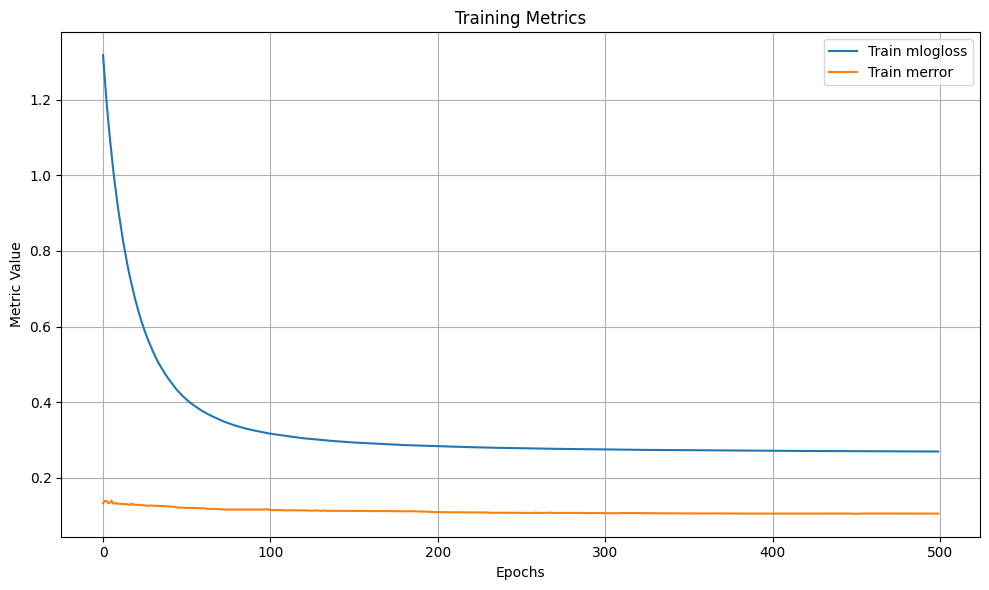

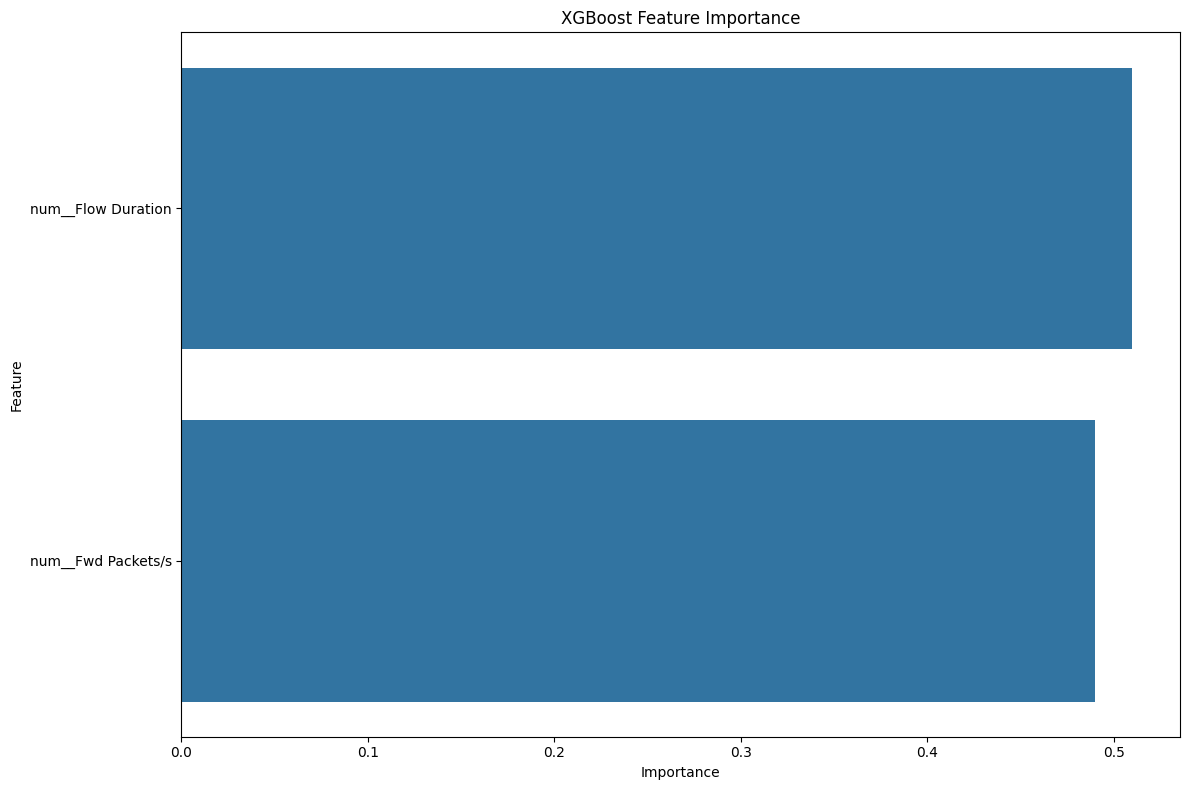

2025-05-17 13:59:16,173 - INFO - XGB sample predictions: [0 3 0 3 2]
2025-05-17 13:59:16,174 - INFO - 
Evaluating models...
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.1s finished
2025-05-17 13:59:16,373 - INFO - RandomForest unique predictions: [0 1 2 3]


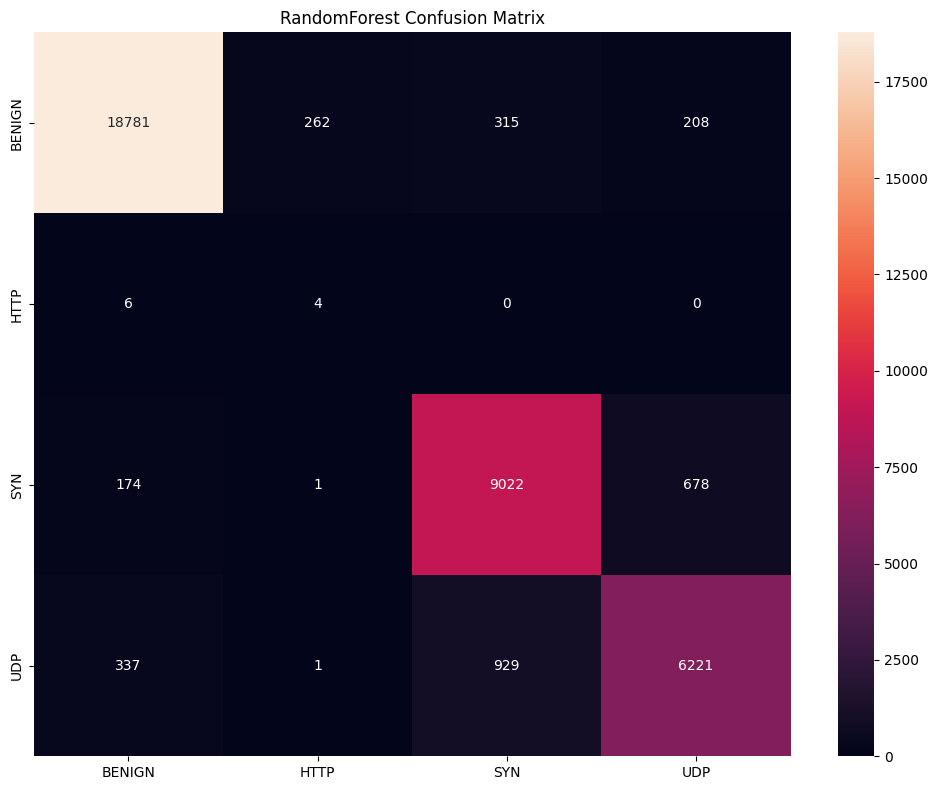

2025-05-17 13:59:16,842 - INFO - SVM unique predictions: [1]


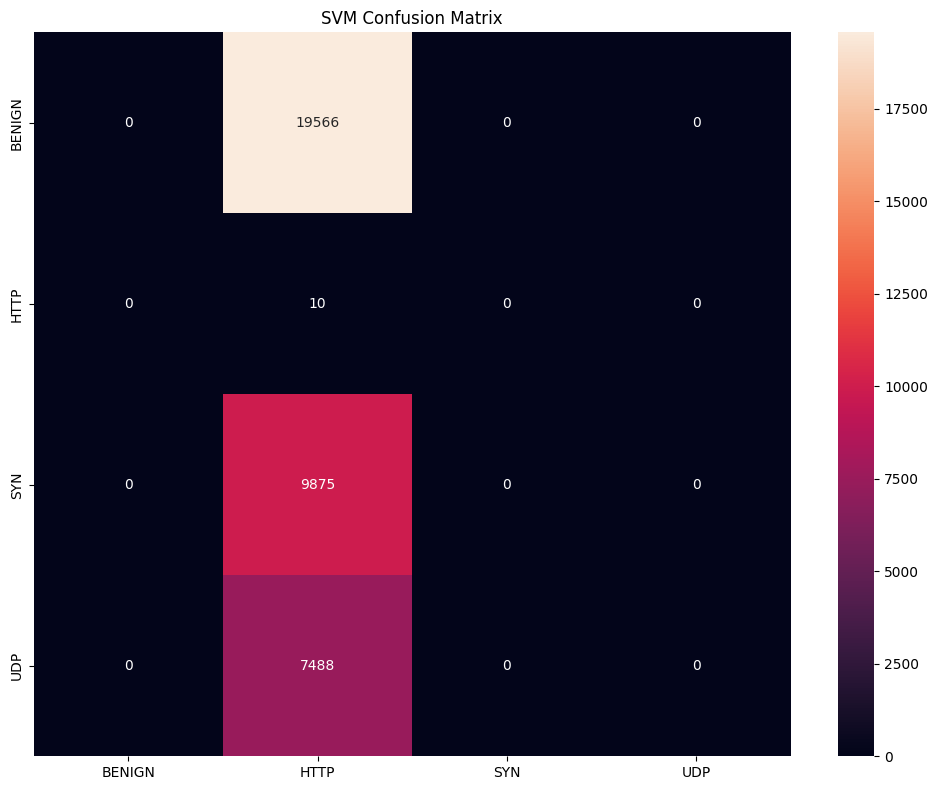

2025-05-17 13:59:17,866 - INFO - XGBoost unique predictions: [0 1 2 3]


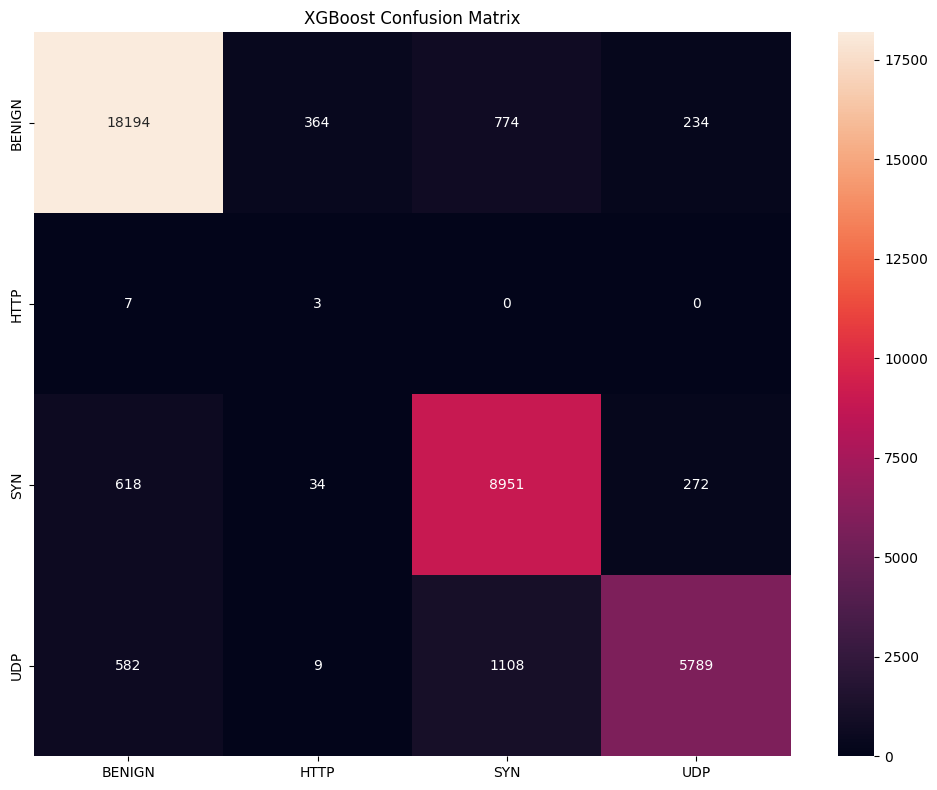

2025-05-17 13:59:18,342 - INFO - Pipeline completed in 30.33 seconds


In [6]:
pipeline_start = time.time()

def log_memory_usage():
    process = psutil.Process()
    mem = process.memory_info().rss / (1024 ** 2)
    logger.info(f"Current memory usage: {mem:.2f} MB")

log_memory_usage()

# Ensure proper label encoding
y_train_encoded = label_encoder.transform(train_df['Label'])  # Use the fitted label_encoder
y_test_encoded = label_encoder.transform(test_df['Label'])    # Don't use y_train/y_test directly

def quick_simulation_test(model, X_test_selected, y_test, class_names, n=3):
    try:
        sample = X_test_selected[:n]
        if hasattr(model, 'n_features_in_'):
            assert sample.shape[1] == model.n_features_in_
                
        preds = model.predict(sample)
        logger.info("\nQuick Simulation Test:")
        for i, (pred, true) in enumerate(zip(preds, y_test[:n])):
            # Ensure consistent label decoding
            logger.info(f"Sample {i+1}: Predicted {class_names[pred]} | Actual {class_names[true]}")
    except Exception as e:
        logger.error(f"Quick test failed: {e}")
        raise

try:
    logger.info("\nStarting feature selection pipeline...")

    # Data conversion (unchanged)
    X_train_np = (
        X_train_processed.toarray() if sparse.issparse(X_train_processed)
        else X_train_processed.to_numpy() if isinstance(X_train_processed, pd.DataFrame)
        else X_train_processed
    )
    y_train_np = label_encoder.transform(balanced_train['Label'])

    # Feature selection (unchanged)
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var = variance_selector.fit_transform(X_train_np)

    try:
        all_features = np.array(preprocessor.get_feature_names_out())
        kept_features = all_features[variance_selector.get_support()]
    except Exception:
        kept_features = np.array([f"f{i}" for i in range(X_train_var.shape[1])])

    # Verify feature importance calculation
    rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
    rf.fit(X_train_var, y_train_np)
    importances = rf.feature_importances_
    
    # Verify features aren't all zero
    if np.all(importances == 0):
        raise ValueError("All feature importances are zero - check your data!")

    importance_df = pd.DataFrame({
        'Feature': kept_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Feature selection
    try:
        selector = SelectFromModel(rf, threshold='median', prefit=True)
        X_train_selected = selector.transform(X_train_var)
        selected_features = kept_features[selector.get_support()]
    except Exception:
        logger.warning("Using fallback feature selection")
        n_features = min(20, X_train_var.shape[1])
        top_idx = np.argsort(importances)[-n_features:]
        X_train_selected = X_train_var[:, top_idx]
        selected_features = kept_features[top_idx]

    plot_feature_distributions(X_train_selected, y_train_np, selected_features)

    # Process test data
    X_test_np = (
        X_test_processed.toarray() if sparse.issparse(X_test_processed)
        else X_test_processed.to_numpy() if isinstance(X_test_processed, pd.DataFrame)
        else X_test_processed
    )
    X_test_var = variance_selector.transform(X_test_np)
    X_test_selected = selector.transform(X_test_var) if 'selector' in locals() else X_test_var[:, top_idx]

    # Verify data before training
    logger.info("\n=== Data Validation ===")
    logger.info(f"Unique y_train values: {np.unique(y_train_np)}")
    logger.info(f"Class distribution: {pd.Series(y_train_np).value_counts()}")
    assert not np.all(X_train_selected == 0), "All training features are zero!"
    assert X_train_selected.shape[1] > 0, "No features selected!"

    # Model training
    logger.info("\nTraining models...")
    models = {}
    
    try:
        rf_model = train_random_forest(X_train_selected, y_train_np, selected_features=selected_features)
        models['RandomForest'] = rf_model
        # Verify predictions
        test_preds = rf_model.predict(X_test_selected[:5])
        logger.info(f"RF sample predictions: {test_preds}")
    except Exception as e:
        logger.error(f"RF failed: {e}")

    try:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)
        svm_model = train_svm(X_train_scaled, y_train_np, selected_features=selected_features)
        models['SVM'] = svm_model
        test_preds = svm_model.predict(X_test_selected[:5])
        logger.info(f"SVM sample predictions: {test_preds}")
    except Exception as e:
        logger.error(f"SVM failed: {e}")

    try:
        xgb_model = train_xgboost(X_train_selected, y_train_np, selected_features=selected_features)
        models['XGBoost'] = xgb_model
        test_preds = xgb_model.predict(X_test_selected[:5])
        logger.info(f"XGB sample predictions: {test_preds}")
    except Exception as e:
        logger.error(f"XGBoost failed: {e}")

    # Proper evaluation with label verification
    logger.info("\nEvaluating models...")
    results = {}
    for model_name, model in models.items():
        try:
            y_pred = model.predict(X_test_selected)
            
            # Verify predictions
            unique_preds = np.unique(y_pred)
            logger.info(f"{model_name} unique predictions: {unique_preds}")
            
            # Ensure predictions align with test labels
            assert set(unique_preds).issubset(set(np.unique(y_test_encoded))), \
                f"Model predicted invalid classes: {set(unique_preds) - set(np.unique(y_test_encoded))}"
            
            report = classification_report(y_test_encoded, y_pred, 
                                        output_dict=True, 
                                        target_names=class_names)
            
            # Force float conversion to prevent 0.0000
            results[model_name] = {
                'accuracy': float(accuracy_score(y_test_encoded, y_pred)),
                'balanced_accuracy': float(balanced_accuracy_score(y_test_encoded, y_pred)),
                'classification_report': {
                    k: {m: float(v) for m,v in report[k].items()}
                    for k in class_names  # Only include class-specific metrics
                }
            }
            
            # Visualisation
            cm = confusion_matrix(y_test_encoded, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', 
                       xticklabels=class_names, 
                       yticklabels=class_names)
            plt.title(f'{model_name} Confusion Matrix')
            plt.tight_layout()
            plt.savefig(f'results/plots/confusion_matrices/{model_name}_confusion.png', dpi=300)
            plt.show()
            plt.close()

        except Exception as e:
            logger.error(f"Evaluation failed for {model_name}: {e}")

    with open('results//metrics/final_metrics.json', 'w') as f:
        json.dump(results, f, indent=2)

    pipeline_time = time.time() - pipeline_start
    logger.info(f"Pipeline completed in {pipeline_time:.2f} seconds")

except Exception as e:
    logger.error(f"Pipeline failed: {str(e)}", exc_info=True)
    raise

### 2.4 Model Comparison

In [7]:
y_train_encoded = y_train_np
y_test_encoded = y_test

comparison_results = []
cached_metrics = {}

for model_name, model in models.items():
    metrics = evaluate_model(model, X_test_selected, y_test_encoded, class_names, selected_features)

    if metrics is None:
        logger.warning(f"No metrics returned for model {model_name}")
        continue

    cached_metrics[model_name] = metrics

    comparison_results.append({
        'Model': model_name,
        'Accuracy': metrics.get('accuracy', 0.0),
        'Balanced Accuracy': metrics.get('balanced_accuracy', 0.0),
        'SYN Precision': metrics['class_reports'].get('SYN', {}).get('precision', 0.0),
        'SYN Recall': metrics['class_reports'].get('SYN', {}).get('recall', 0.0),
        'UDP Precision': metrics['class_reports'].get('UDP', {}).get('precision', 0.0),
        'UDP Recall': metrics['class_reports'].get('UDP', {}).get('recall', 0.0),
        'HTTP F1': metrics['class_reports'].get('HTTP', {}).get('f1-score', 0.0),
        'BENIGN Precision': metrics['class_reports'].get('BENIGN', {}).get('precision', 0.0)
    })

comparison_df = pd.DataFrame(comparison_results).set_index('Model')
comparison_df.to_csv("results/metrics/model_comparison.csv")
display(comparison_df.style.background_gradient(cmap='Blues'))

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished


,Accuracy,Balanced Accuracy,SYN Precision,SYN Recall,UDP Precision,UDP Recall,HTTP F1,BENIGN Precision
Model,,,,,,,,
RandomForest,0.921194,0.776074,0.878823,0.913620,0.875334,0.830796,0.028777,0.973210
SVM,0.000271,0.250000,0.000000,0.000000,0.000000,0.000000,0.000541,0.000000
XGBoost,0.891659,0.727353,0.826272,0.906430,0.919619,0.773104,0.014286,0.937787


### 2.5 Attack Performance

In [8]:
attack_metrics = []

for model_name, metrics in cached_metrics.items():
    row = {
        'Model': model_name,
        'Accuracy': metrics.get('accuracy', 0.0),
        'Balanced Accuracy': metrics.get('balanced_accuracy', 0.0),
    }

    for label in ['SYN', 'UDP', 'HTTP', 'BENIGN']:
        class_metrics = metrics['class_reports'].get(label, {})
        row[f'{label} Precision'] = class_metrics.get('precision', 0.0)
        row[f'{label} Recall'] = class_metrics.get('recall', 0.0)
        row[f'{label} F1'] = class_metrics.get('f1-score', 0.0)

    attack_metrics.append(row)

attack_df = pd.DataFrame(attack_metrics).set_index('Model')
attack_df.to_csv("results/metrics/attack_performance.csv")
display(attack_df.style.background_gradient(cmap='Oranges'))

,Accuracy,Balanced Accuracy,SYN Precision,SYN Recall,SYN F1,UDP Precision,UDP Recall,UDP F1,HTTP Precision,HTTP Recall,HTTP F1,BENIGN Precision,BENIGN Recall,BENIGN F1
Model,,,,,,,,,,,,,,
RandomForest,0.921194,0.776074,0.878823,0.913620,0.895884,0.875334,0.830796,0.852484,0.014925,0.400000,0.028777,0.973210,0.959879,0.966499
SVM,0.000271,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000271,1.000000,0.000541,0.000000,0.000000,0.000000
XGBoost,0.891659,0.727353,0.826272,0.906430,0.864497,0.919619,0.773104,0.840020,0.007317,0.300000,0.014286,0.937787,0.929878,0.933816


## 3. Advanced Analysis

### 3.1 Hyperparameter Tuning

2025-05-17 13:59:19,682 - INFO - 
=== Starting Comprehensive Model Tuning ===
2025-05-17 13:59:19,703 - INFO - 
=== Starting Hyperparameter Tuning ===
2025-05-17 13:59:19,704 - INFO - 
Tuning RandomForest...


Fitting 3 folds for each of 36 candidates, totalling 108 fits


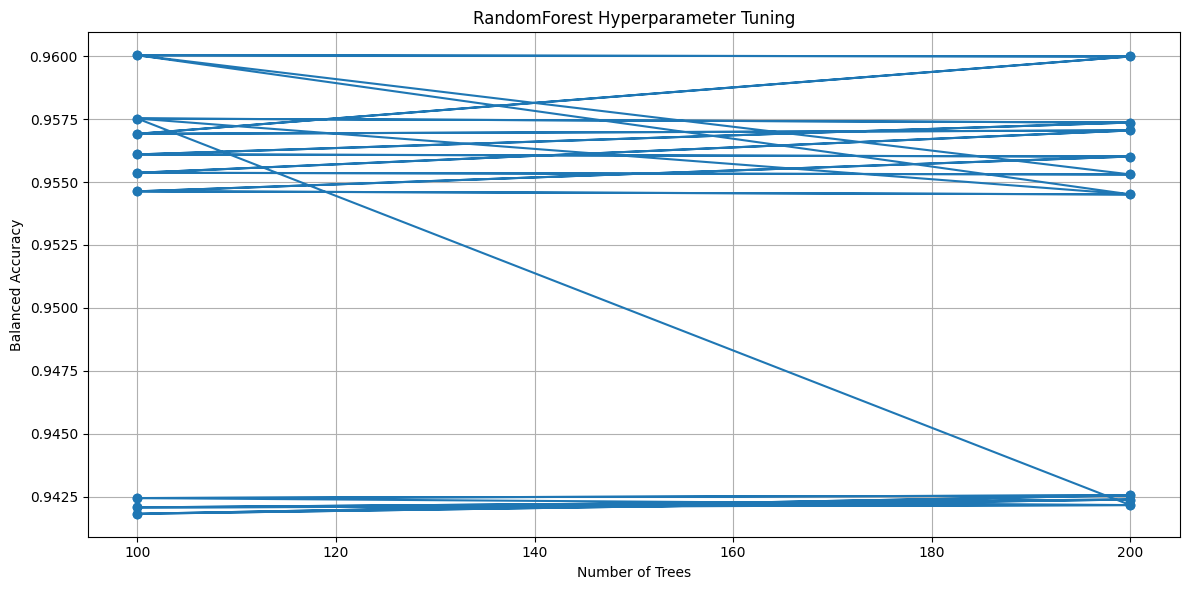

2025-05-17 14:01:35,137 - INFO - 
Tuning SGD...


Fitting 3 folds for each of 8 candidates, totalling 24 fits


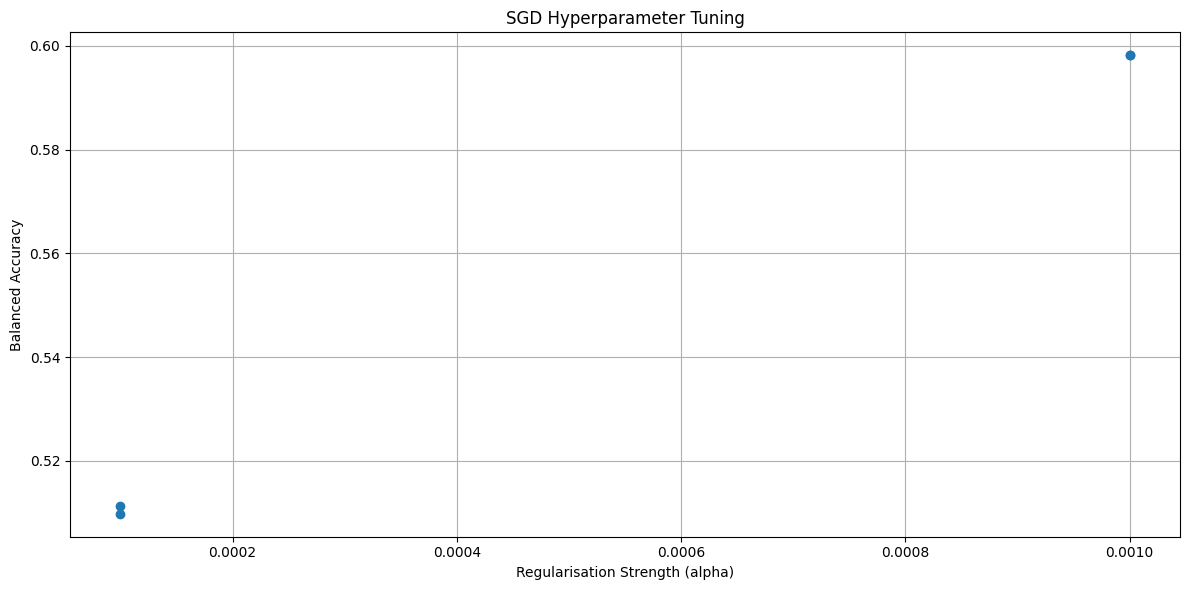

2025-05-17 14:01:39,665 - INFO - 
Tuning XGBoost...


Fitting 3 folds for each of 16 candidates, totalling 48 fits


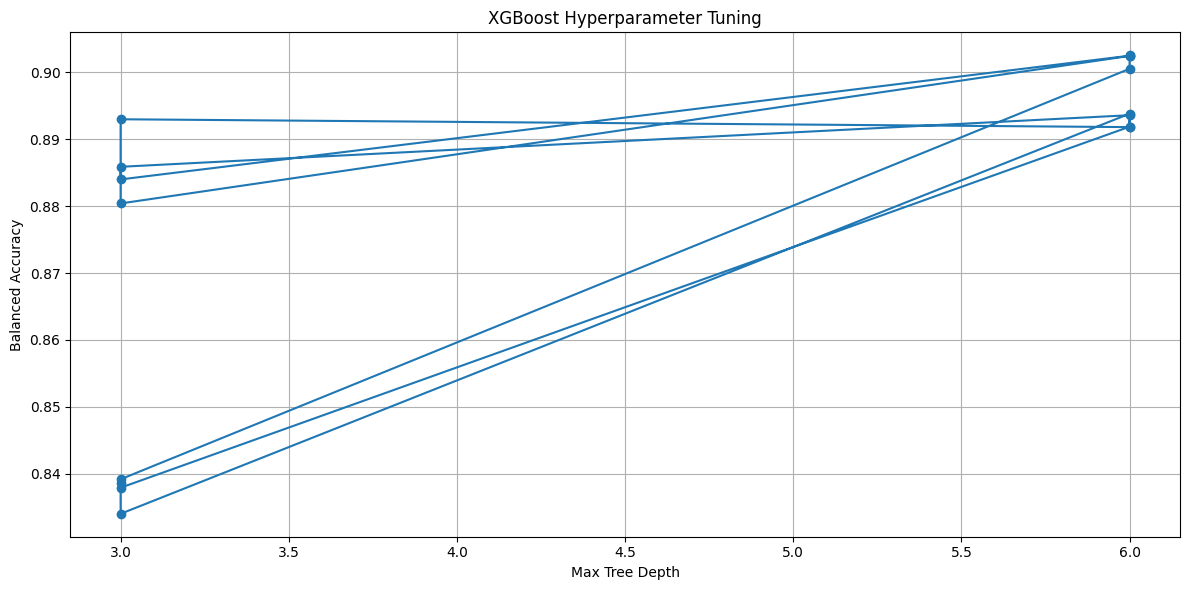

2025-05-17 14:02:21,462 - INFO - 
=== Tuning Results Summary ===


,best_score,val_accuracy,val_balanced_accuracy
Model,,,
RandomForest,0.960035,0.964902,0.967781
SGD,0.598200,0.448482,0.599825
XGBoost,0.902567,0.941722,0.906786


2025-05-17 14:02:21,536 - INFO - 
=== Final Test Evaluation ===


,Test Accuracy,Test Balanced Accuracy,SYN F1,UDP F1,HTTP F1,BENIGN F1,BENIGN Precision
Model,,,,,,,
RandomForest,0.934947,0.788829,0.000000,0.000000,0.000000,0.000000,0.000000
SGD,0.437018,0.571755,0.000000,0.000000,0.000000,0.000000,0.000000
XGBoost,0.941119,0.794150,0.000000,0.000000,0.000000,0.000000,0.000000


2025-05-17 14:02:21,702 - INFO - 
=== Tuning Complete ===


In [9]:
def tune_hyperparameters(X_train, y_train):
    """Enhanced hyperparameter tuning with full results reporting"""
    try:
        logger.info("\n=== Starting Hyperparameter Tuning ===")
        
        # 1. Prepare data
        X_train = X_train.toarray() if sparse.issparse(X_train) else X_train
        y_train = np.array(y_train)
        
        # 2. Set up parameter grids for each model
        param_grids = {
            'RandomForest': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'max_features': ['sqrt', 'log2']
            },
            'SGD': {
                'alpha': [0.0001, 0.001],
                'penalty': ['l2', 'elasticnet'],
                'learning_rate': ['optimal', 'adaptive']
            },
            'XGBoost': {
                'max_depth': [3, 6],
                'learning_rate': [0.1, 0.3],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0]
            }
        }

        # 3. Initialise models with common settings
        models = {
            'RandomForest': RandomForestClassifier(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1
            ),
            'SGD': SGDClassifier(
                loss='modified_huber',
                class_weight='balanced',
                random_state=RANDOM_STATE
            ),
            'XGBoost': XGBClassifier(
                objective='multi:softmax',
                random_state=RANDOM_STATE,
                n_jobs=-1,
                tree_method='hist'
            )
        }

        # 4. Perform tuning for each model
        best_models = {}
        results = {}
        
        for model_name, model in models.items():
            logger.info(f"\nTuning {model_name}...")
            
            # Create validation set
            X_train_sub, X_val, y_train_sub, y_val = train_test_split(
                X_train, y_train,
                test_size=0.2,
                random_state=RANDOM_STATE,
                stratify=y_train
            )
            
            # Grid search with cross-validation
            grid = GridSearchCV(
                model,
                param_grids[model_name],
                cv=3,
                n_jobs=-1,
                scoring='balanced_accuracy',
                verbose=2
            )
            grid.fit(X_train_sub, y_train_sub)
            
            # Store results
            best_models[model_name] = grid.best_estimator_
            results[model_name] = {
                'best_params': grid.best_params_,
                'best_score': grid.best_score_,
                'val_accuracy': accuracy_score(y_val, grid.best_estimator_.predict(X_val)),
                'val_balanced_accuracy': balanced_accuracy_score(y_val, grid.best_estimator_.predict(X_val))
            }
            
            # Save detailed CV results
            cv_results = pd.DataFrame(grid.cv_results_)
            cv_results.to_csv(f"results/metrics/{model_name}_tuning_results.csv", index=False)
            
            # Plot performance across parameters
            plot_tuning_results(cv_results, model_name)

        # 5. Display and save final results
        logger.info("\n=== Tuning Results Summary ===")
        results_df = pd.DataFrame.from_dict(results, orient='index')
        # Format and save tuning summary as a table
        summary_df = results_df[['best_score', 'val_accuracy', 'val_balanced_accuracy']]
        summary_df.index.name = 'Model'

        # Save and display
        summary_df.to_csv("results/metrics/tuning_summary.csv")
        display(summary_df.style.background_gradient(cmap='Purples'))

        
        # Save best models
        for model_name, model in best_models.items():
            joblib.dump(model, f"models/tuned_{model_name.lower()}_model.pkl")
        
        return best_models
        
    except Exception as e:
        logger.error(f"Hyperparameter tuning failed: {e}")
        raise

def plot_tuning_results(cv_results, model_name):
    """Visualize hyperparameter tuning results"""
    try:
        # Plot accuracy vs parameters
        plt.figure(figsize=(12, 6))
        
        # Extract relevant parameters based on model
        if model_name == 'RandomForest':
            param = 'param_n_estimators'
            plt.xlabel('Number of Trees')
        elif model_name == 'XGBoost':
            param = 'param_max_depth'
            plt.xlabel('Max Tree Depth')
        else:  # SGD
            param = 'param_alpha'
            plt.xlabel('Regularisation Strength (alpha)')
        
        plt.plot(cv_results[param], cv_results['mean_test_score'], 'o-')
        plt.ylabel('Balanced Accuracy')
        plt.title(f'{model_name} Hyperparameter Tuning')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"results/plots/tuning/{model_name}_tuning_curve.png")
        plt.show()
        plt.close()
        
    except Exception as e:
        logger.error(f"Could not plot tuning results: {e}")

# Main execution with enhanced reporting
try:
    logger.info("\n=== Starting Comprehensive Model Tuning ===")
    
    # Get processed data
    X_train_tune = X_train_processed.toarray() if sparse.issparse(X_train_processed) else X_train_processed
    y_train_tune = label_encoder.transform(balanced_train['Label'])
    
    # Run enhanced tuning
    best_models = tune_hyperparameters(X_train_tune, y_train_tune)
    
        # Evaluate on test set
    logger.info("\n=== Final Test Evaluation ===")
    test_metrics = {}
    for name, model in best_models.items():
        y_pred = model.predict(X_test_processed)
        test_metrics[name] = {
            'accuracy': accuracy_score(y_test_encoded, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test_encoded, y_pred),
            'classification_report': classification_report(y_test_encoded, y_pred, output_dict=True)
        }
    # Create summary table
    summary_rows = []
    for name, metrics in test_metrics.items():
        row = {
            "Model": name,
            "Test Accuracy": metrics.get("accuracy", 0.0),
            "Test Balanced Accuracy": metrics.get("balanced_accuracy", 0.0),
        }
        
        # Extract key class-level metrics
        for cls in ['SYN', 'UDP', 'HTTP', 'BENIGN']:
            cls_report = metrics['classification_report'].get(cls, {})
            row[f"{cls} F1"] = cls_report.get("f1-score", 0.0)
            if cls == 'BENIGN':
                row[f"{cls} Precision"] = cls_report.get("precision", 0.0)

        summary_rows.append(row)

    # Display/save table
    tuned_df = pd.DataFrame(summary_rows).set_index("Model")
    tuned_df.to_csv("results/metrics/final_tuned_summary.csv")
    display(tuned_df.style.background_gradient(cmap="Greens"))

    # Save final metrics
    with open("results/metrics/final_tuned_metrics.json", "w") as f:
        json.dump(test_metrics, f, indent=2)
        
    logger.info("\n=== Tuning Complete ===")
    
except Exception as e:
    logger.error(f"Comprehensive tuning failed: {e}")
    raise

### 3.2 Cross Validation

2025-05-17 14:02:21,725 - INFO - 
Running cross-validation for RandomForest...
2025-05-17 14:02:30,310 - INFO - RandomForest CV Mean Balanced Accuracy: 0.9671 (±0.0007)
2025-05-17 14:02:30,310 - INFO - 
Running cross-validation for SGD...
2025-05-17 14:02:31,602 - INFO - SGD CV Mean Balanced Accuracy: 0.5985 (±0.0428)
2025-05-17 14:02:31,606 - INFO - 
Running cross-validation for XGBoost...
2025-05-17 14:02:39,728 - INFO - XGBoost CV Mean Balanced Accuracy: 0.9037 (±0.0077)
2025-05-17 14:02:39,728 - INFO - Final memory usage: 855.53 MB
2025-05-17 14:02:39,728 - INFO - Best model selected: RandomForest


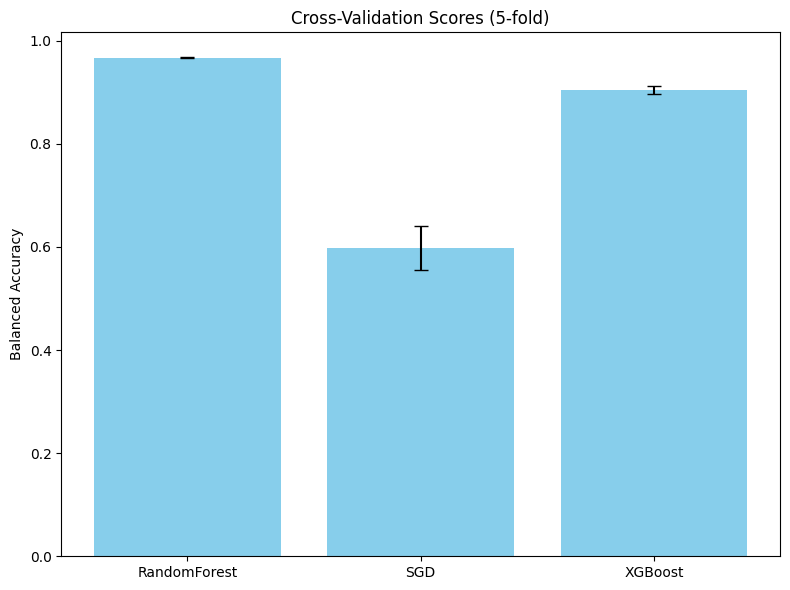

,CV Mean Balanced Accuracy,CV Std Dev
Model,,
RandomForest,0.967115,0.000657
SGD,0.598459,0.042832
XGBoost,0.903713,0.007728


In [10]:
cv_scores_all = {}

for name, model in best_models.items():
    try:
        logger.info(f"\nRunning cross-validation for {name}...")
        scores = cross_val_score(
            model,
            X_train_tune,
            y_train_tune,
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1
        )
        cv_scores_all[name] = {
            'scores': scores.tolist(),
            'mean': float(scores.mean()),
            'std': float(scores.std())
        }
        logger.info(f"{name} CV Mean Balanced Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")
    except Exception as e:
        logger.error(f"{name} cross-validation failed: {e}")

# Memory check
mem_usage = psutil.Process().memory_info().rss / (1024 ** 2)
logger.info(f"Final memory usage: {mem_usage:.2f} MB")

best_model_name = max(cv_scores_all, key=lambda x: cv_scores_all[x]['mean'])
best_model = best_models[best_model_name]
logger.info(f"Best model selected: {best_model_name}")

means = [v['mean'] for v in cv_scores_all.values()]
stds = [v['std'] for v in cv_scores_all.values()]
labels = list(cv_scores_all.keys())

plt.figure(figsize=(8, 6))
plt.bar(labels, means, yerr=stds, capsize=5, color='skyblue')
plt.ylabel('Balanced Accuracy')
plt.title('Cross-Validation Scores (5-fold)')
plt.tight_layout()
plt.savefig("results/plots/cv_score_summary.png")
plt.show()
plt.close()

# Convert CV results to table format
cv_summary = []
for name, score_dict in cv_scores_all.items():
    cv_summary.append({
        "Model": name,
        "CV Mean Balanced Accuracy": score_dict["mean"],
        "CV Std Dev": score_dict["std"]
    })

# Create and display DataFrame
cv_summary_df = pd.DataFrame(cv_summary).set_index("Model")
cv_summary_df.to_csv("results/metrics/cv_score_table.csv")
display(cv_summary_df.style.background_gradient(cmap='Greens'))

# Save key results
with open('results/metrics/final_cv_scores.json', 'w') as f:
    json.dump(cv_scores_all, f, indent=2)

### 3.3 Error Analysis

2025-05-17 14:02:39,992 - INFO - 
Running enhanced error analysis...


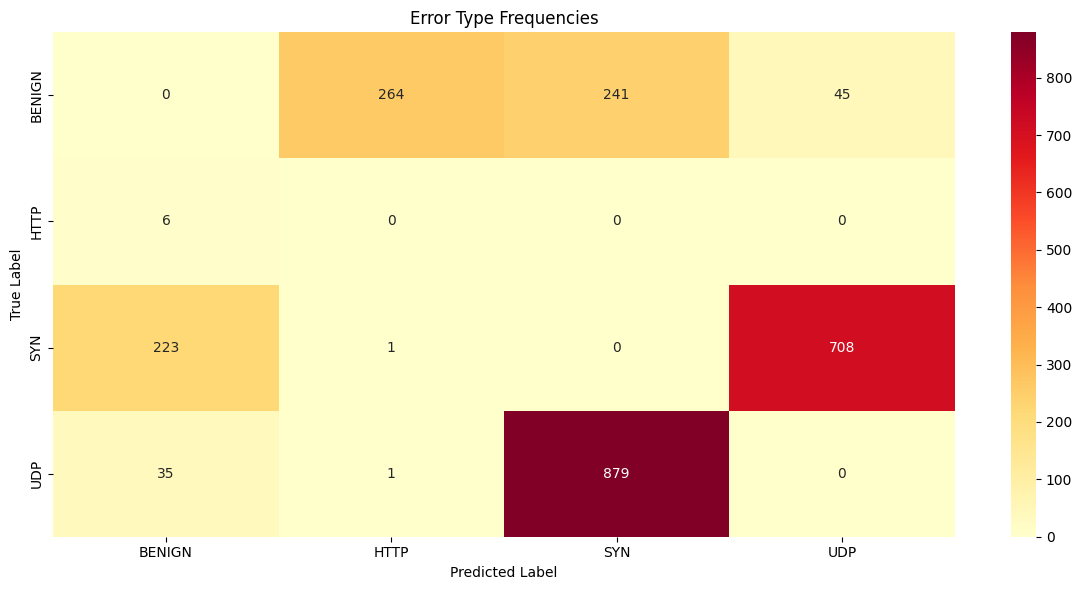

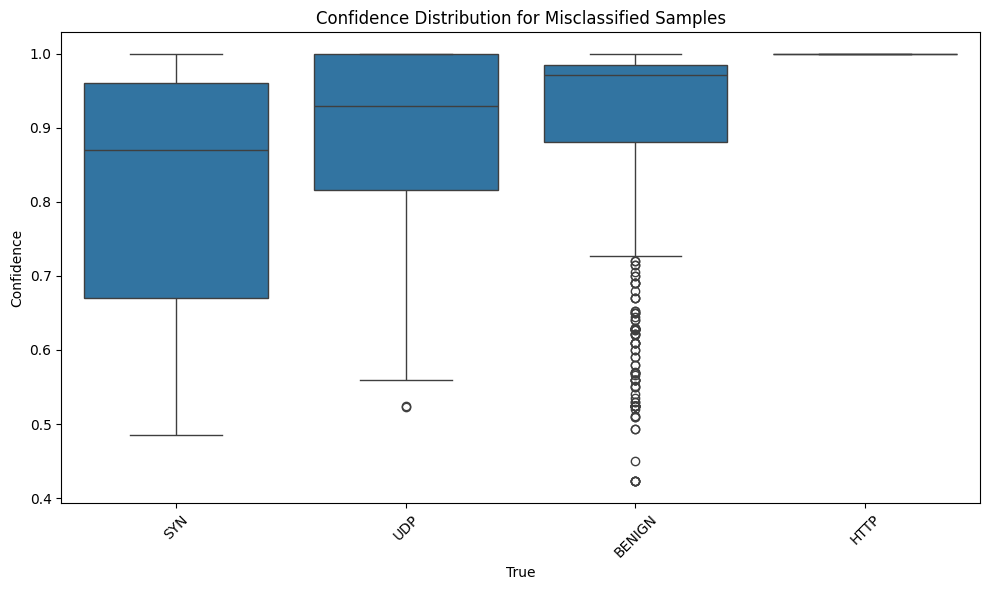

,True Label,Predicted Label,Count
0,UDP,SYN,879


,Feature,Importance
0,UDP_Rate_Anomaly,0.320023
1,Fwd Packets/s,0.282671
2,HTTP_Request_Rate,0.247329
3,SYN_Per_Second,0.149744
4,Total Fwd Packets,0.000233


2025-05-17 14:02:41,928 - INFO - Saved error analysis to results/error_analysis/error_details.csv
2025-05-17 14:02:42,030 - INFO - Pipeline execution completed successfully.


In [ ]:
def analyse_errors(model, X_test, y_test, selected_features, n_samples=5):
    """Enhanced error analysis for multi-class classification"""
    try:
        logger.info("\nRunning enhanced error analysis...")

        # Ensure selected_features is a list of strings
        selected_features = selected_features.tolist() if isinstance(selected_features, np.ndarray) else selected_features

        if not hasattr(model, 'predict_proba'):
            logger.error("Model doesn't support probability predictions")
            return None

        y_pred = model.predict(X_test)
        probas = model.predict_proba(X_test)

        # Ensure selected_features matches the number of columns in X_test
        if len(selected_features) != X_test.shape[1]:
            raise ValueError(f"The number of selected features ({len(selected_features)}) does not match the number of columns in X_test ({X_test.shape[1]})")

        errors = pd.DataFrame(X_test, columns=selected_features)
        errors['True'] = [label_encoder.classes_[i] for i in y_test]
        errors['Predicted'] = [label_encoder.classes_[i] for i in y_pred]
        errors['Confidence'] = np.max(probas, axis=1)
        errors = errors[errors['True'] != errors['Predicted']]

        # Error frequency heatmap
        error_stats = errors.groupby(['True', 'Predicted']).size().reset_index(name='Count')
        error_types = error_stats.pivot(index='True', columns='Predicted', values='Count').fillna(0)

        plt.figure(figsize=(12, 6))
        sns.heatmap(error_types, annot=True, fmt='.0f', cmap='YlOrRd')
        plt.title('Error Type Frequencies')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f"results/error_analysis/{model.__class__.__name__}_error_types.png", dpi=300)
        plt.show()
        plt.close()

        # Confidence distribution
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=errors, x='True', y='Confidence')
        plt.title('Confidence Distribution for Misclassified Samples')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"results/error_analysis/{model.__class__.__name__}_error_confidence.png", dpi=300)
        plt.show()
        plt.close()

        # Most common error type
        most_common_error = error_stats.sort_values('Count', ascending=False).iloc[0]
        # Display most common error as a single-row DataFrame
        most_common_df = pd.DataFrame([{
            'True Label': most_common_error['True'],
            'Predicted Label': most_common_error['Predicted'],
            'Count': most_common_error['Count']
        }])
        display(most_common_df.style.set_caption("Most Common Misclassification"))

        # Display top 5 features if available
        if hasattr(model, 'feature_importances_'):
            top_features = pd.Series(model.feature_importances_, index=selected_features).nlargest(5).reset_index()
            top_features.columns = ['Feature', 'Importance']
            display(top_features.style.set_caption("Top Features Contributing to Misclassification"))

        return errors.sort_values('Confidence').head(n_samples)

    except Exception as e:
        logger.error(f"Enhanced error analysis failed: {e}")
        raise
    
selected_features = [
    'SYN_Per_Second',        # For detecting SYN flood attacks
    'UDP_Rate_Anomaly',      # For spotting anomalously high UDP rates
    'HTTP_Request_Rate',     # For WebDDoS detection
    'Fwd Packets/s',         # General traffic speed
    'Total Fwd Packets'      # Basic packet volume
]

# Run analysis
error_df = analyse_errors(best_model, X_test_processed, y_test_encoded, selected_features)

# Save CSV
if error_df is not None:
    error_df.to_csv("results/error_analysis/error_details.csv", index=False)
    logger.info("Saved error analysis to results/error_analysis/error_details.csv")
else:
    logger.info("No misclassifications to save.")

# Cleanup
gc.collect()
logger.info("Pipeline execution completed successfully.")

## 4. Real-Time Detection and Network Simulation

### 4.1 Real-Time Detection

In [ ]:
class DDoSDetector:
    def __init__(self):
        """Enhanced detector that evaluates all models and uses consensus voting"""
        # Load all models and preprocessing components
        self.models = {
            'rf': self._load_model("models/tuned_randomforest_model.pkl"),
            'svm': self._load_model("models/tuned_sgd_model.pkl"),
            'xgb': self._load_model("models/tuned_xgboost_model.pkl")
        }
        self.preprocessor = joblib.load("models/preprocessor.pkl")
        self.label_encoder = joblib.load("models/label_encoder.pkl")
        self.class_names = self.label_encoder.classes_
        
        # Attack state tracking with model consensus
        self.attack_state = {
            'current_attack': None,
            'start_time': None,
            'packet_count': 0,
            'model_agreement': 0,
            'confidence_scores': []
        }
        
        # Performance tracking
        self.performance_stats = {
            'total_packets': 0,
            'processing_times': [],
            'model_performance': {name: {'correct': 0, 'total': 0} for name in self.models}
        }
    
    def _load_model(self, path):
        """Safe model loading with validation"""
        try:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Model file not found: {path}")
            model = joblib.load(path)
            logger.info(f"Successfully loaded {os.path.basename(path)}")
            return model
        except Exception as e:
            logger.error(f"Failed to load model {path}: {e}")
            raise
    
    def process_packet(self, packet: dict) -> dict:
        """Process packet using all models and return consensus results"""
        start_time = time.time()
        self.performance_stats['total_packets'] += 1
        
        try:
            # Validate input
            required_fields = [
                'Flow Duration', 'Total Fwd Packets', 'Protocol',
                'SYN Flag Count', 'Fwd Packets/s'
            ]
            if not all(field in packet for field in required_fields):
                raise ValueError(f"Packet missing required fields: {required_fields}")
            
            # Preprocess packet
            packet_df = pd.DataFrame([packet])
            processed = self.preprocessor.transform(packet_df)
            
            # Get predictions from all models
            predictions = {}
            for model_name, model in self.models.items():
                if hasattr(model, "predict_proba"):
                    proba = model.predict_proba(processed)[0]
                    confidence = np.max(proba)
                    prediction = self.class_names[np.argmax(proba)]
                else:
                    prediction = self.class_names[model.predict(processed)[0]]
                    confidence = 1.0  # Default confidence if model doesn't support probabilities
                
                predictions[model_name] = {
                    'prediction': prediction,
                    'confidence': confidence
                }
            
            # Determine consensus prediction
            final_prediction = self._get_consensus_prediction(predictions)
            
            # Update attack state
            self._update_attack_state(final_prediction, predictions)
            
            # Update performance stats
            proc_time = time.time() - start_time
            self.performance_stats['processing_times'].append(proc_time)
            true_label = packet.get('true_label')
            if true_label:
                for model_name, pred in predictions.items():
                    self.performance_stats['model_performance'][model_name]['total'] += 1
                    if pred['prediction'] == true_label:
                        self.performance_stats['model_performance'][model_name]['correct'] += 1
            
            return {
                'final_prediction': final_prediction,
                'model_predictions': predictions,
                'processing_time': proc_time
            }
            
        except Exception as e:
            logger.error(f"Packet processing failed: {e}")
            return {'error': str(e)}
    
    def _get_consensus_prediction(self, predictions):
        """Determine final prediction using model consensus"""
        # Count votes from each model
        votes = {}
        for model_name, pred in predictions.items():
            attack_type = pred['prediction']
            if attack_type in votes:
                votes[attack_type] += 1
            else:
                votes[attack_type] = 1
        
        # Get prediction with most votes
        max_votes = max(votes.values())
        candidates = [k for k, v in votes.items() if v == max_votes]
        
        # If tie, use confidence scores
        if len(candidates) > 1:
            conf_scores = {}
            for candidate in candidates:
                total_conf = sum(
                    pred['confidence'] 
                    for model_name, pred in predictions.items() 
                    if pred['prediction'] == candidate
                )
                conf_scores[candidate] = total_conf
            
            return max(conf_scores.items(), key=lambda x: x[1])[0]
        
        return candidates[0]
    
    def _update_attack_state(self, final_prediction, model_predictions):
        """Track ongoing attacks using model consensus"""
        if final_prediction != 'BENIGN':
            # Calculate model agreement
            agreement = sum(
                1 for pred in model_predictions.values() 
                if pred['prediction'] == final_prediction
            )
            
            # New attack detected
            if self.attack_state['current_attack'] != final_prediction:
                self.attack_state = {
                    'current_attack': final_prediction,
                    'start_time': time.time(),
                    'packet_count': 1,
                    'model_agreement': agreement,
                    'confidence_scores': [pred['confidence'] for pred in model_predictions.values()]
                }
                self._send_alert(final_prediction, model_predictions)
            else:
                # Ongoing attack
                self.attack_state['packet_count'] += 1
                self.attack_state['model_agreement'] = agreement
                self.attack_state['confidence_scores'] = [pred['confidence'] for pred in model_predictions.values()]
                
                # Send periodic updates
                if time.time() - self.attack_state['start_time'] > 5:  # Every 5 seconds
                    self._send_alert(final_prediction, model_predictions)
        else:
            # Attack ended
            if self.attack_state['current_attack'] is not None:
                logger.info(
                    f"Attack ended: {self.attack_state['current_attack']} "
                    f"({self.attack_state['packet_count']} packets)"
                )
                self.attack_state = {
                    'current_attack': None,
                    'start_time': None,
                    'packet_count': 0,
                    'model_agreement': 0,
                    'confidence_scores': []
                }
    
    def _send_alert(self, attack_type, model_predictions):
        """Generate detailed alert with model consensus"""
        avg_confidence = np.mean(self.attack_state['confidence_scores'])
        model_votes = "\n".join(
            f"  • {name}: {pred['prediction']} ({pred['confidence']:.1%})"
            for name, pred in model_predictions.items()
        )
        
        alert_msg = (
            f"DDoS ALERT - Type: {attack_type}\n"
            f"Model Consensus: {self.attack_state['model_agreement']}/3 models agree\n"
            f"Model Details:\n{model_votes}\n"
            f"Avg Confidence: {avg_confidence:.1%}\n"
            f"Packets: {self.attack_state['packet_count']}\n"
            f"Duration: {time.time() - self.attack_state['start_time']:.1f}s"
        )
        logger.warning(alert_msg)
    
    def get_performance_stats(self):
        """Return comprehensive performance statistics"""
        avg_time = np.mean(self.performance_stats['processing_times']) if self.performance_stats['processing_times'] else 0
        throughput = 1/avg_time if avg_time > 0 else 0
        
        # Calculate model accuracy if we have ground truth (would need to be implemented)
        model_acc = {
            name: (
                f"{(stats['correct']/stats['total']):.1%}" 
                if stats['total'] > 0 else "N/A"
            )
            for name, stats in self.performance_stats['model_performance'].items()
        }
        
        return {
            'total_packets': self.performance_stats['total_packets'],
            'avg_processing_time_ms': avg_time * 1000,
            'current_throughput_pkt/s': throughput,
            'ongoing_attack': self.attack_state['current_attack'],
            'model_accuracy': model_acc
        }

### 4.2 Network Simulation

In [ ]:
def simulate_network_traffic(duration: int = 10, pps: int = 1000, attack_prob: float = 0.01):
    """Realistic traffic simulator with configurable attack probability"""
    # Initialise detector with performance tracking
    detector = DDoSDetector()
    stats = {
        'total_packets': 0,
        'attack_packets': 0,
        'detected_attacks': 0,
        'false_positives': 0,
        'processing_times': []
    }
    
    def generate_packet(is_attack=False):
        """Generate realistic network packet data"""
        base = {
            'Flow Duration': max(0.001, np.random.exponential(0.1)),
            'Total Fwd Packets': max(1, int(np.random.normal(10, 5))),
            'Protocol': np.random.choice([6, 17]),  # TCP or UDP
            'SYN Flag Count': 0,
            'Fwd Packets/s': np.random.uniform(100, 1000)
        }

        if is_attack:
            attack_type = np.random.choice(['SYN', 'UDP', 'HTTP'])
            if attack_type == 'SYN':
                base['SYN Flag Count'] = min(50, base['Total Fwd Packets'])
                base['Protocol'] = 6  # TCP
            elif attack_type == 'UDP':
                base['Fwd Packets/s'] *= 50
                base['Protocol'] = 17  # UDP
            else:  # HTTP
                base['Total Fwd Packets'] = max(100, base['Total Fwd Packets'])
            return base, attack_type
        else:
            return base, 'BENIGN'
    
    # Run simulation
    start_time = time.time()
    with tqdm(total=duration * pps, desc="Simulating traffic") as pbar:
        for _ in range(duration * pps):
            # Simulate attack bursts with configurable probability
            is_attack = np.random.random() < attack_prob
            if is_attack:
                burst_size = np.random.randint(5, 15)
                for _ in range(burst_size):
                    packet, attack_type = generate_packet(is_attack=True)
                    packet['true_label'] = attack_type
                    result = detector.process_packet(packet)
                    final_prediction = result['final_prediction']
                    
                    stats['attack_packets'] += 1
                    if final_prediction != 'BENIGN':
                        stats['detected_attacks'] += 1
                    stats['total_packets'] += 1
                    stats['processing_times'].append(result['processing_time'])
                    pbar.update(1)
            else:
                packet, attack_type = generate_packet()
                packet['true_label'] = attack_type
                result = detector.process_packet(packet)
                final_prediction = result['final_prediction']
                
                if final_prediction != 'BENIGN':
                    stats['false_positives'] += 1
                stats['total_packets'] += 1
                stats['processing_times'].append(result['processing_time'])
                pbar.update(1)
    
    # Calculate final statistics
    total_time = time.time() - start_time
    stats['duration'] = total_time
    stats['throughput'] = stats['total_packets'] / total_time
    
    # Print summary report
    print("\n=== Simulation Summary ===")
    print(f"Total packets processed: {stats['total_packets']}")
    print(f"Attack packets: {stats['attack_packets']} ({stats['attack_packets']/stats['total_packets']:.1%})")
    print(f"Detected attacks: {stats['detected_attacks']} ({stats['detected_attacks']/max(1, stats['attack_packets']):.1%} detection rate)")
    print(f"False positives: {stats['false_positives']} ({stats['false_positives']/max(1, stats['total_packets']-stats['attack_packets']):.1%})")
    print(f"Throughput: {stats['throughput']:.1f} packets/sec")
    
    # Add detector performance stats
    detector_stats = detector.get_performance_stats()
    print(f"\nDetector Performance:")
    print(f"Average processing time: {detector_stats['avg_processing_time_ms']:.2f} ms")
    print(f"Current throughput: {detector_stats['current_throughput_pkt/s']:.1f} packets/sec")
    print("Model accuracy estimates:")
    for model, acc in detector_stats['model_accuracy'].items():
        print(f"  {model}: {acc}")
    
    return {**stats, **{'detector_stats': detector_stats}}

### 4.3 Testing

In [ ]:
if __name__ == "__main__":
    # Initialise logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("ddos_simulation.log"),
            logging.StreamHandler()
        ]
    )
    
    # Test the detector with sample packets
    print("=== Testing DDoSDetector ===")
    detector = DDoSDetector()
    
    test_packets = [
        {'Flow Duration': 0.1, 'Total Fwd Packets': 10, 'Protocol': 6, 'SYN Flag Count': 1, 'Fwd Packets/s': 500},  # Benign
        {'Flow Duration': 0.01, 'Total Fwd Packets': 50, 'Protocol': 6, 'SYN Flag Count': 50, 'Fwd Packets/s': 5000},  # SYN
        {'Flow Duration': 0.05, 'Total Fwd Packets': 1000, 'Protocol': 17, 'SYN Flag Count': 0, 'Fwd Packets/s': 50000},  # UDP
        {'Flow Duration': 1.0, 'Total Fwd Packets': 200, 'Protocol': 6, 'SYN Flag Count': 0, 'Fwd Packets/s': 200}  # HTTP
    ]
    
    for i, packet in enumerate(test_packets):
        result = detector.process_packet(packet)
        print(f"Test {i+1}:")
        print(f"  Final prediction: {result['final_prediction']}")
        print("  Model predictions:")
        for model, pred in result['model_predictions'].items():
            print(f"    {model}: {pred['prediction']} (confidence: {pred['confidence']:.1%})")
        print(f"  Processing time: {result['processing_time']*1000:.2f} ms\n")
    
    # Run simulation
    print("\n=== Starting Network Simulation ===")
    simulation_stats = simulate_network_traffic(
        duration=5,  # seconds
        pps=500,     # packets per second
        attack_prob=0.02  # 2% chance of attack
    )

    logging.info("=== Final Simulation Stats ===")
    for key, value in simulation_stats.items():
        if key != 'detector_stats':
            logging.info(f"{key}: {value}")
    
    print("\nFull Simulation Stats:")
    import json
    print(json.dumps(simulation_stats, indent=2))

=== Testing DDoSDetector ===


2025-05-17 14:02:42,340 - INFO - Successfully loaded tuned_randomforest_model.pkl
2025-05-17 14:02:42,357 - INFO - Successfully loaded tuned_sgd_model.pkl
2025-05-17 14:02:42,446 - INFO - Successfully loaded tuned_xgboost_model.pkl
2025-05-17 14:02:42,772 - WARNING - DDoS ALERT - Type: UDP
Model Consensus: 3/3 models agree
Model Details:
  • rf: UDP (71.5%)
  • svm: UDP (56.1%)
  • xgb: UDP (98.4%)
Avg Confidence: 75.4%
Packets: 1
Duration: 0.0s


Test 1:
  Final prediction: BENIGN
  Model predictions:
    rf: BENIGN (confidence: 74.2%)
    svm: BENIGN (confidence: 65.7%)
    xgb: BENIGN (confidence: 100.0%)
  Processing time: 167.91 ms

Test 2:
  Final prediction: BENIGN
  Model predictions:
    rf: BENIGN (confidence: 75.2%)
    svm: BENIGN (confidence: 100.0%)
    xgb: BENIGN (confidence: 99.9%)
  Processing time: 75.20 ms

Test 3:
  Final prediction: UDP
  Model predictions:
    rf: UDP (confidence: 71.5%)
    svm: UDP (confidence: 56.1%)
    xgb: UDP (confidence: 98.4%)
  Processing time: 59.70 ms



2025-05-17 14:02:42,824 - INFO - Attack ended: UDP (1 packets)


Test 4:
  Final prediction: BENIGN
  Model predictions:
    rf: BENIGN (confidence: 69.3%)
    svm: HTTP (confidence: 36.2%)
    xgb: BENIGN (confidence: 99.9%)
  Processing time: 51.85 ms


=== Starting Network Simulation ===


2025-05-17 14:02:43,049 - INFO - Successfully loaded tuned_randomforest_model.pkl
2025-05-17 14:02:43,059 - INFO - Successfully loaded tuned_sgd_model.pkl
2025-05-17 14:02:43,092 - INFO - Successfully loaded tuned_xgboost_model.pkl


Simulating traffic:   0%|          | 0/2500 [00:00<?, ?it/s]

2025-05-17 14:02:43,181 - WARNING - DDoS ALERT - Type: UDP
Model Consensus: 2/3 models agree
Model Details:
  • rf: UDP (64.4%)
  • svm: UDP (55.6%)
  • xgb: BENIGN (65.9%)
Avg Confidence: 62.0%
Packets: 1
Duration: 0.0s
2025-05-17 14:02:43,448 - INFO - Attack ended: UDP (4 packets)
2025-05-17 14:02:43,507 - WARNING - DDoS ALERT - Type: UDP
Model Consensus: 2/3 models agree
Model Details:
  • rf: UDP (51.4%)
  • svm: UDP (55.6%)
  • xgb: BENIGN (95.4%)
Avg Confidence: 67.5%
Packets: 1
Duration: 0.0s
2025-05-17 14:02:43,565 - INFO - Attack ended: UDP (1 packets)
2025-05-17 14:02:43,713 - WARNING - DDoS ALERT - Type: UDP
Model Consensus: 3/3 models agree
Model Details:
  • rf: UDP (65.4%)
  • svm: UDP (55.7%)
  • xgb: UDP (73.6%)
Avg Confidence: 64.9%
Packets: 1
Duration: 0.0s
2025-05-17 14:02:43,814 - INFO - Attack ended: UDP (2 packets)
2025-05-17 14:02:43,919 - WARNING - DDoS ALERT - Type: UDP
Model Consensus: 3/3 models agree
Model Details:
  • rf: UDP (61.6%)
  • svm: UDP (55.6%)
  


=== Simulation Summary ===
Total packets processed: 2877
Attack packets: 420 (14.6%)
Detected attacks: 188 (44.8% detection rate)
False positives: 1109 (45.1%)
Throughput: 19.1 packets/sec

Detector Performance:
Average processing time: 51.81 ms
Current throughput: 19.3 packets/sec
Model accuracy estimates:
  rf: 51.5%
  svm: 7.6%
  xgb: 68.3%

Full Simulation Stats:
{
  "total_packets": 2877,
  "attack_packets": 420,
  "detected_attacks": 188,
  "false_positives": 1109,
  "processing_times": [
    0.06226706504821777,
    0.06231093406677246,
    0.06456971168518066,
    0.05782914161682129,
    0.07779765129089355,
    0.05889439582824707,
    0.058464765548706055,
    0.04892325401306152,
    0.053041696548461914,
    0.04627490043640137,
    0.052977561950683594,
    0.05301523208618164,
    0.04735755920410156,
    0.05187368392944336,
    0.05375862121582031,
    0.053249359130859375,
    0.04784846305847168,
    0.05132293701171875,
    0.05068349838256836,
    0.05465769767761